# Data preparation

Open **train2017.tsv**, clear tweets of links, words with # and @ and unnecessary symbols. Replace some positive and negative emoticons with 'positive_tag'/'negative_tag' correspondigly (for better features later). <br> Tweet clearing involves as well tokenizing, removing stopwords and lemmatizing words.

In [1]:
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import StemmerI, RegexpStemmer, LancasterStemmer, ISRIStemmer, PorterStemmer, SnowballStemmer, RSLPStemmer
from nltk.stem import  WordNetLemmatizer
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
import pickle
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import gensim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import svm
import os
import re

%matplotlib inline

#read train2017.csv and cleanup
data = pd.read_csv("twitter_data/train2017.tsv", engine='python', sep="\t+", escapechar='\\', header=None, names=['id1','id2','sent','tweet'])
data.info()
print "\n"
for col in data.columns:
    print col + ": " + str(len(data[col].unique())) + " unique values."

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28061 entries, 0 to 28060
Data columns (total 4 columns):
id1      28061 non-null int64
id2      28061 non-null object
sent     28061 non-null object
tweet    28061 non-null object
dtypes: int64(1), object(3)
memory usage: 877.0+ KB


id1: 28060 unique values.
id2: 22284 unique values.
sent: 3 unique values.
tweet: 28061 unique values.


#### Functions with implementation of the above

In [2]:
#clear tweets

def clear_tweets(data):
    tweets = [re.sub(r'https?:\/\/[^ ]*', '',s).strip() for s in data['tweet']] #clear links
    
    #replace emoticons with positive/negative tags !!!
    pos_regex = '[:;]-?[)Dp]+|<3'
    neg_regex = ':-?\'?[(/Oo]+'
    tweets = [re.sub(pos_regex, ' positive_tag ',s).strip() for s in tweets]
    tweets = [re.sub(neg_regex, ' negative_tag ',s).strip() for s in tweets]
    
    #clear tweets of everything else not necessary
    tweets = [re.sub(r'#[^ ]*', '', s).strip() for s in tweets]  #clear words with hashtag
    tweets = [re.sub(r'@[^ ]*', '', s).strip() for s in tweets]  #clear words with @ sign
    tweets = [re.sub("[^A-Za-z_' ]+", "", s).strip() for s in tweets]    #clear all others
    return tweets

def tokenize_tweets(tweets):
    tokens = []
    for sentence in tweets:
        #tokens.append(word_tokenize(sentence))
        tokens.append([w.lower() for w in word_tokenize(sentence)])
    return tokens

def extra_clear(tokens):
    #take words, clears dots etc
    for idx, item in enumerate(tokens):
        for value in item:
            if ("'" in value or "'" == value) and value != "c'mon":
                item.remove(value)
            elif value == "st" or value == "th":
                item.remove(value)
        tokens[idx] = item
    return tokens

def remove_stopwords(tokens):
    filtered = []
    for lst in tokens:
        filtered.append([w for w in lst if not w in stopwords.words('english')])
    return filtered

In [3]:
#Lemmatize with POS Tags
#it may take some minutes !!
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_words(tokens):
    lemmatizer = WordNetLemmatizer()
    lems = []
    for lst in tokens:
        lems.append([ lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lst ])
    return lems

In [4]:
#check if directory exists
if not os.path.isdir("pkl_files"):
    os.mkdir("pkl_files")

if not os.path.isfile("pkl_files/words.pkl"):
    tweets = clear_tweets(data)
    words = tokenize_tweets(tweets)
    words = extra_clear(words)
    words = remove_stopwords(words)
    lems = lemmatize_words(words)
    pickle.dump(lems, open("pkl_files/words.pkl", "wb"))
    
lems = pickle.load(open("pkl_files/words.pkl", "rb"))
print "End result:"
print lems[:10]

End result:
[['gas', 'house', 'hit', u'go', 'chapel', 'hill', 'sat', 'positive_tag'], ['theo', 'walcott', 'still', 'shit', 'watch', 'rafa', 'johnny', 'deal', 'saturday'], ['gsp', 'fan', 'hate', 'nick', 'diaz', 'ca', 'wait', 'february'], ['iranian', 'general', u'say', 'israel', 'iron', 'dome', 'ca', 'deal', u'missile', 'keep', u'talk', 'like', 'may', 'end', u'find'], ['tehran', 'mon', 'amour', 'obama', u'try', 'establish', u'tie', u'mullah', 'via', 'barack', 'obama', 'vote', 'mitt', 'romney'], ['sat', 'whole', 'movie', 'harry', 'ron', 'christmas', 'ohlawd'], ['j', 'davlar', 'main', u'rival', 'team', 'poland', 'hopefully', 'make', 'successful', 'end', 'tough', 'week', 'training', 'tomorrow'], [u'talk', 'act', 'sat', u'decide', 'want', 'go', 'college', u'apply', u'college', 'everything', 'college', u'stress'], ['happy', u'valentine', 'day', u'trend', 'february', 'june', 'smh'], ['may', 'superbowl', 'dallas', 'dallas', 'ai', u'win', 'superbowl', 'quarterback', 'owner']]


Keep a list of tuples with every word and its frequency of occurence in each tweet

In [5]:
#fix tuples
total = []
for lst in lems:
    if len(lst) > 0:
        count = Counter(lst)
        total.append(count.most_common(len(count)))
print len(total)

28059


## Analyze data of training set

Some code for finding useful statistics and wordclouds for presenting

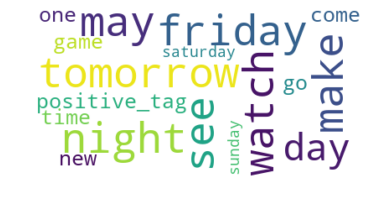

In [6]:
# find most common words in whole corpus -> wordcloud

buf = []
for lst in lems:
    for value in lst:
        buf.append(value)
count = Counter(buf)

#freq is a string with the 20 most common words
freq = ""
for x in count.most_common(20):
    freq += x[0] + ' '
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(freq)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

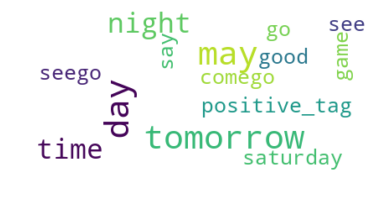

In [7]:
# find most frequent words for each sentiment category -> unique(set) -> wordcloud

#positive
pos_words = []
neg_words = []
neutral_words = []
for idx, item in enumerate(lems):
    for x in item:
        if data['sent'][idx] == "positive":
            pos_words.append(x)
        elif data['sent'][idx] == "negative":
            neg_words.append(x)
        else:
            neutral_words.append(x)

count1 = Counter(pos_words)
count2 = Counter(neg_words)
count3 = Counter(neutral_words)

out = ' '.join([x[0] for x in count1.most_common(10)])
out += ' '.join([x[0] for x in count2.most_common(10)])
out += ' '.join([x[0] for x in count3.most_common(10)])

wordcloud = WordCloud(max_font_size=40, max_words=20, background_color="white").generate(out)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
#find number of unique tokens
unique = set()
for lst in lems:           #stin lems einai oi pio "kathares" lekseis
    for value in lst:
        unique.add(value)
print len(unique)
print list(unique)[50:100]

27851
['stern', 'dne', 'dng', 'dna', 'brizo', 'dnc', 'catchy', 'cannibal', 'degreesa', 'dnt', 'music', 'therefore', 'musia', 'dnr', 'catchh', 'yahoo', 'luttrell', 'hermann', 'tradeins', 'bummy', u'unpack', 'intake', 'morally', 'momentgoing', 'locker', u'tomahawk', 'matilda', 'wana', 'wang', 'wand', 'hyatt', 'wank', 'want', 'munzee', 'absolute', 'mcmuffin', u'travel', 'tftbl', 'dannok', 'selfesteem', 'festuc', 'flossin', 'wrong', 'shreya', "'new", u'tulip', 'romper', 'jialat', 'aargh', 'burleigh']


## Open testing set and prepare data

In [9]:
test_data = pd.read_csv("twitter_data/test2017.tsv", engine='python', sep="\t+", escapechar='\\', header=None, names=['id1','id2','sent','tweet'])
test_data.columns

Index([u'id1', u'id2', u'sent', u'tweet'], dtype='object')

In [10]:
#open gold.csv for f1 score only!

val_data = pd.read_csv("twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", engine='python', sep="\t+", header=None,names=['id','sent'])
print val_data.columns
print val_data.info()

Index([u'id', u'sent'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12284 entries, 0 to 12283
Data columns (total 2 columns):
id      12284 non-null int64
sent    12284 non-null object
dtypes: int64(1), object(1)
memory usage: 192.0+ KB
None


#### Make X,y sets for validation and test sets

**yval**:  Contains y of training (validation) set<br>
**ycor**:  Contains y of testing set<br>
**Χ**:     For testing set

In [11]:
#y value, only for validation
y = data.sent
yval = []
for i in range(len(y)):
    if len(lems[i]) == 0:
        continue
    v = y[i]
    if v == 'neutral':
        yval.append(0)
    if v == 'positive':
        yval.append(1)
    if v == 'negative':
        yval.append(-1)
print len(yval)

28059


In [12]:
#X and y values --> FOR test2017.csv

X = test_data.tweet
tmp = val_data.sent

ycor = []
for v in tmp:
    if v == 'neutral':
        ycor.append(0)
    if v == 'positive':
        ycor.append(1)
    if v == 'negative':
        ycor.append(-1)
print len(ycor)

12284


Same list of tuples as above, but for test data

In [13]:
words = []
for s in X:
    words.append(s.split())

total_test = []
for lst in words:
    count = Counter(lst)
    total_test.append(count.most_common(len(count)))
print total_test[:5]

[[('#Singer', 1), ('Full', 1), ('80%', 1), ('Ariana', 1), ('#Actress', 1), ('Grande', 1), ('Ari', 1), ('By', 1), ('#ArianaGrande', 1)], [('KIIS', 1), ('Ariana', 1), ('Truly', 1), ('Burbank', 1), ('FM', 1), ('Grande', 1), ('listening', 1), ('in', 1), ('party', 1), ('CD', 1), ('Yours', 1), ('#ArianaGrande', 1)], [('House', 1), ('Washington', 1), ('Ariana', 1), ('Grande', 1), ('in', 1), ('Easter', 1), ('White', 1), ('Egg', 1), ('Roll', 1), ('#ArianaGrande', 1)], [('Box', 1), ('Like', 1), ('New', 1), ('Sweet', 1), ('100%', 1), ('In', 1), ('Candy', 1), ('Ariana', 1), ('3.4', 1), ('#Musics', 1), ('Grande', 1), ('Sealed', 1), ('ML', 1), ('#CD', 1), ('100', 1), ('Authenic', 1), ('oz', 1)], [('SIDE', 2), ("#LOTB'", 1), ('@arianagrande', 1), ('#musically', 1), ('TO', 1), ('#arianagrande', 1), ('#comunidadgay', 1), ('#lgbt', 1), ('#sidetoside', 1)]]


## Bag of words 

**NOTE**: All the useful data saved in **.pkl** files will exist in **"pkl_files"** directory

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

#concatenate words into sentences
con_tweets = []
for lst in lems:
    if len(lst)>0:
        con_tweets.append(' '.join(lst))
print len(con_tweets)


#make bag-of-words
if not os.path.isfile("pkl_files/bow_train.pkl"):
    bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=3000, stop_words='english')
    bow_xtrain = bow_vectorizer.fit_transform(con_tweets)
    pickle.dump(bow_xtrain, open("pkl_files/bow_train.pkl", "wb"))

bow_xtrain = pickle.load(open( "pkl_files/bow_train.pkl", "rb" ))
print bow_xtrain.shape

28059
(28059, 3000)


In [15]:
#bag of words for testing
if not os.path.isfile("pkl_files/bow_test.pkl"):
    bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=3000, stop_words='english') 
    bow_xtest = bow_vectorizer.fit_transform(X)  #X : a list with the actual tweets to test 
    pickle.dump(bow_xtest, open("pkl_files/bow_test.pkl", "wb"))      #save in bow.pkl
    
bow_xtest = pickle.load(open( "pkl_files/bow_test.pkl", "rb" ))
print(bow_xtest.shape)

(12284, 3000)


## TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

if not os.path.isfile("pkl_files/ifidf_train.pkl"):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=3000, stop_words='english')
    tfidf_temp = tfidf_vectorizer.fit_transform(con_tweets)
    pickle.dump(tfidf_temp, open("pkl_files/tfidf_train.pkl", "wb"))        #save tf_idf.pkl
    
tfidf_train = pickle.load(open( "pkl_files/tfidf_train.pkl", "rb" ))
print tfidf_train.shape

(28059, 3000)


In [17]:
#tfidf for testing

if not os.path.isfile("pkl_files/ifidf_test.pkl"):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=3000, stop_words='english')
    tfidf_temp = tfidf_vectorizer.fit_transform(X)
    pickle.dump(tfidf_temp, open("pkl_files/tfidf_test.pkl", "wb"))        #save tf_idf.pkl
    
tfidf_test = pickle.load(open( "pkl_files/tfidf_test.pkl", "rb" ))
print tfidf_test.shape

(12284, 3000)


## Word embeddings

In [18]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

if not os.path.isfile("pkl_files/wemb_train.pkl"):
    model_w2v = gensim.models.Word2Vec(
    lems,     #give lemmatized words!
    size=300, # desired no. of features/independent variables
    window=5, # context window size
    min_count=1,
    sg = 1, # 1 for skip-gram model
    hs = 0,
    negative = 10, # for negative sampling
    workers= 2, # no.of cores
    seed = 34)
    
    model_w2v.train(lems, total_examples= len(lems), epochs=20)
    pickle.dump(model_w2v, open("pkl_files/wemb_train.pkl", "wb"))

model_w2v_train = pickle.load(open( "pkl_files/wemb_train.pkl", "rb" ))

#little test :p
model_w2v_train.wv.most_similar(positive="mcgregor")

[('conor', 0.9781937599182129),
 ('ndround', 0.6552845239639282),
 ('humbleness', 0.6272361278533936),
 ('aldo', 0.6258029937744141),
 ('recovers', 0.6216188669204712),
 ('faber', 0.6211392879486084),
 ('breathtaking', 0.6193422675132751),
 ('avecessi', 0.6108793020248413),
 ('urijah', 0.6097930073738098),
 ('ronda', 0.6081383228302002)]

In [19]:
#word embeddings for testing

if not os.path.isfile("pkl_files/wemb_test.pkl"):
    model_w2v = gensim.models.Word2Vec(
    words,     #give our set X - its words!
    size=300, # desired no. of features/independent variables
    window=5, # context window size
    min_count=1,
    sg = 1, # 1 for skip-gram model
    hs = 0,
    negative = 10, # for negative sampling
    workers= 2, # no.of cores
    seed = 34)
    
    model_w2v.train(lems, total_examples= len(words), epochs=20)
    pickle.dump(model_w2v, open("pkl_files/wemb_test.pkl", "wb"))
    
model_w2v_test = pickle.load(open( "pkl_files/wemb_test.pkl", "rb" ))

Word embeddings **visualization**

In [20]:
#function to show the word embeddings visualization

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsne_plot(model):
    labels = []
    tokens = []
    count = 0
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        count += 1
        if count == 1000:
            break
        
    tsne_model = TSNE(perplexity=40, n_components=2,
                        init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(180):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
    plt.show()

/home/errikos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


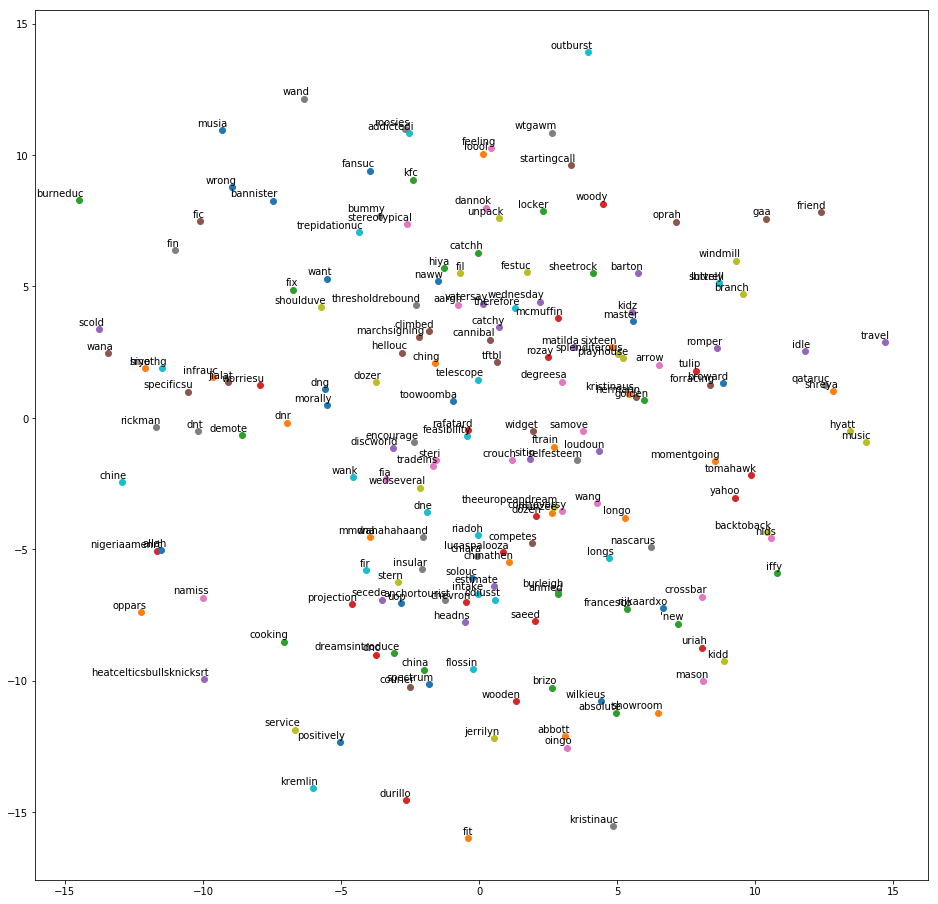

In [21]:
#call

tsne_plot(model_w2v_train)

#### Combine the vectors of each word into one for the whole tweet

In [22]:
#func to add all vectors of words into one (for every tweet)

def fix_vectors(tuples, model):
    tv = []
    for i in range(len(tuples)):
        sent = tuples[i]
        temp = []
        count=0
        for tpl in sent:
            v = model[tpl[0]]
            v = v*tpl[1]
            temp.append(v)
            count += 1
        if temp:
            a = reduce(lambda x,y: x+y, temp)
            tv.append(a/count)
    return tv

Lexicon analysis --> search lexicon files, compute the **-mean-** value of valence of each tweet and add as extra feature.<br>
In our case, each word will have **300** features and if we perform searches in **N** files, each vector will end up having 300+N features

In [23]:
#lex_file must contain whole path from current to lexicon

import collections as cl

def lexicon_analysis(lex_file, total):
    lex_data = pd.read_csv(lex_file, engine='python', sep="\t+", escapechar='\\', header=None, names=['word','val'])
    word_dict = cl.defaultdict()
    for row in lex_data.itertuples():
        word_dict[row.word] = row.val

    lexicon_vals = []
    for i in range(len(total)):
        tweet = total[i]
        sum = 0
        for word, count in tweet:
            if word_dict.get(word):
            #word in lexicon
                sum += word_dict[word] * count
        lexicon_vals.append(sum)

    for i,v in enumerate(lexicon_vals):
        if v < 0:
            lexicon_vals[i] = -1
        if v == 0:
            lexicon_vals[i] = 0
        if v > 0:
            lexicon_vals[i] = 1
    return lexicon_vals

In [24]:
tweet_vectors = fix_vectors(total, model_w2v_train)
print "Total length: ", len(tweet_vectors)
print "Length of individual vector: ", len(tweet_vectors[0])

tweet_vectors_test = fix_vectors(total_test, model_w2v_test)
print "Total length: ", len(tweet_vectors_test)
print "Length of individual vector: ", len(tweet_vectors_test[0])

/home/errikos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


Total length:  28059
Length of individual vector:  300
Total length:  12284
Length of individual vector:  300


#### Add some extra features in each vector

Count positive/negative tags in tweets

In [25]:
index=0
for i in range(len(con_tweets)):
    tweet_vectors[index] = np.append(tweet_vectors[index], [con_tweets[i].count("positive_tag"), con_tweets[i].count("negative")])
    index += 1

In [26]:
pos_count, neg_count = [],[]
pos_regex = '[:;]-?[)Dp]+|<3'
neg_regex = ':-?\'?[(/Oo]+'
for sent in X:
    plen = len(re.findall(pos_regex, sent))
    pos_count.append(plen) if plen > 0 else pos_count.append(0)
    nlen = len(re.findall(neg_regex, sent))
    neg_count.append(nlen) if nlen > 0 else neg_count.append(0)
    
#add them to tweet_vectors_test
index=0
for i in range(len(words)):
    tweet_vectors_test[index] = np.append(tweet_vectors_test[index], [pos_count[index], neg_count[index]])
    index += 1

In [27]:
#run above function for the wanted files in lexica
v1_train = lexicon_analysis("lexica/affin/affin.txt", total)
v2_train = lexicon_analysis("lexica/emotweet/valence_tweet.txt", total)
v3_train = lexicon_analysis("lexica/generic/generic.txt", total)
v4_train = lexicon_analysis("lexica/mydict/mydict.txt", total)

#add the vectors calculated to the tweets
i=0
for index in range(len(tweet_vectors)):
    tweet_vectors[index] = np.append(tweet_vectors[index], [v1_train[index], v2_train[index], v3_train[index], v4_train[index], len(total[i])])
    i += 1
print len(tweet_vectors[0])

307


In [29]:
#run above function for the wanted files in lexica
v1_test = lexicon_analysis("lexica/affin/affin.txt", total_test)
v2_test = lexicon_analysis("lexica/emotweet/valence_tweet.txt", total_test)
v3_test = lexicon_analysis("lexica/generic/generic.txt", total_test)
v4_test = lexicon_analysis("lexica/mydict/mydict.txt", total_test)

#add the vectors calculated to the tweets
i=0
for index in range(len(tweet_vectors_test)):
    tweet_vectors_test[index] = np.append(tweet_vectors_test[index], [v1_test[index], v2_test[index], v3_test[index], v4_test[index], len(words[i])])
    i += 1
print len(tweet_vectors_test[0])

307


## SVM

**BOW** and validation set

In [30]:
#split training set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(bow_xtrain, yval, random_state=42, test_size=0.2)
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(xtrain_bow[:5000], ytrain[:5000])

In [31]:
prediction_bow = svc.predict(xvalid_bow)
svm_score_bow_train = f1_score(yvalid, prediction_bow, average='micro')
print svm_score_bow_train

0.5803635067712045


**BOW** and testing set

In [32]:
prediction_bow = svc.predict(bow_xtest)
svm_score_bow_test = f1_score(ycor, prediction_bow, average='micro')
print svm_score_bow_test

0.39807880169325954


**TF_IDF** and validation set

In [33]:
xtrain_idf, xvalid_idf, ytrain, yvalid = train_test_split(tfidf_train, yval, random_state=42, test_size=0.2)
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(xtrain_idf[:5000], ytrain[:5000])

In [34]:
prediction_idf = svc.predict(xvalid_idf)
svm_score_idf_train = f1_score(yvalid, prediction_idf, average='micro')
print svm_score_idf_train

0.6170705630791162


**TF_IDF** and testing set

In [35]:
prediction_idf = svc.predict(tfidf_test)
svm_score_idf_test = f1_score(ycor, prediction_idf, average='micro')
print svm_score_idf_test

0.42144252686421363


**Word Embeddings** and validation set

In [36]:
xtrain_we, xvalid_we, ytrain, yvalid = train_test_split(tweet_vectors, yval, random_state=42, test_size=0.2)
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(xtrain_we[:6000], ytrain[:6000])

In [37]:
prediction_we = svc.predict(xvalid_we)
svm_score_we_train = f1_score(yvalid, prediction_we, average='micro')
print svm_score_we_train

0.6234853884533144


**Word Embeddings** and testing set

In [38]:
prediction_we = svc.predict(tweet_vectors_test)
svm_score_we_test = f1_score(ycor, prediction_we, average='micro')
print svm_score_we_test

0.4752523607945295


## KNN

**BOW** and validation set

In [39]:
from sklearn.neighbors import KNeighborsClassifier

xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(bow_xtrain, yval, random_state=42, test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(xtrain_bow[:5000], ytrain[:5000])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform')

In [40]:
prediction_bow = knn.predict(xvalid_bow)
knn_score_bow_train = f1_score(yvalid, prediction_bow, average="micro")
print knn_score_bow_train

0.4476122594440485


**BOW** and testing set

In [41]:
prediction_bow = knn.predict(bow_xtest)
knn_score_bow_test = f1_score(ycor, prediction_bow, average="micro")
print knn_score_bow_test

0.48314881146206445


**TF_IDF** and validation set

In [42]:
xtrain_idf, xvalid_idf, ytrain, yvalid = train_test_split(tfidf_train, yval, random_state=42, test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(xtrain_idf[:5000], ytrain[:5000])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform')

In [43]:
prediction_idf = knn.predict(xvalid_idf)
knn_score_idf_train = f1_score(yvalid, prediction_idf, average="micro")
print knn_score_idf_train

0.43745545260156815


**TF_IDF** and testing set

In [44]:
prediction_idf = knn.predict(tfidf_test)
knn_score_idf_test = f1_score(ycor, prediction_idf, average="micro")
print knn_score_idf_test

0.4832302181699772


**Word Embeddings** and validation set

In [45]:
xtrain_we, xvalid_we, ytrain, yvalid = train_test_split(tweet_vectors, yval, random_state=42, test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(xtrain_we[:6000], ytrain[:6000])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform')

In [46]:
prediction_we = knn.predict(xvalid_we)
knn_score_we_train = f1_score(yvalid, prediction_we, average="micro")
print knn_score_we_train

0.5915894511760513


**Word Embeddings** and testing set

In [47]:
prediction_we = knn.predict(tweet_vectors_test)
knn_score_we_test = f1_score(ycor, prediction_we,  average='micro')
print knn_score_we_test

0.4969065450993162


### Show f1 score in plots

**SVM**

In [48]:
svm_scores = [svm_score_bow_test, svm_score_bow_train, svm_score_idf_test, svm_score_idf_train, svm_score_we_test, svm_score_we_train]
knn_scores = [knn_score_bow_test, knn_score_bow_train, knn_score_idf_test, knn_score_idf_train, knn_score_we_test, knn_score_we_train]
labels = ("bow test", "bow_train", "tf_idf test", "tf_idf train", "w-embbed test", "w-embbed train")

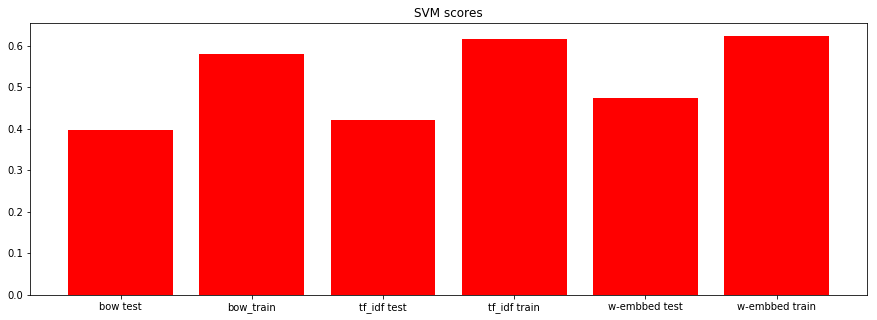

In [49]:
x = np.arange(6)

plt.figure(figsize=(15, 5))
plt.title("SVM scores")
plt.bar(range(len(svm_scores)), svm_scores, color="r", align="center")
plt.xticks(x, labels)
plt.show()

**KNN**

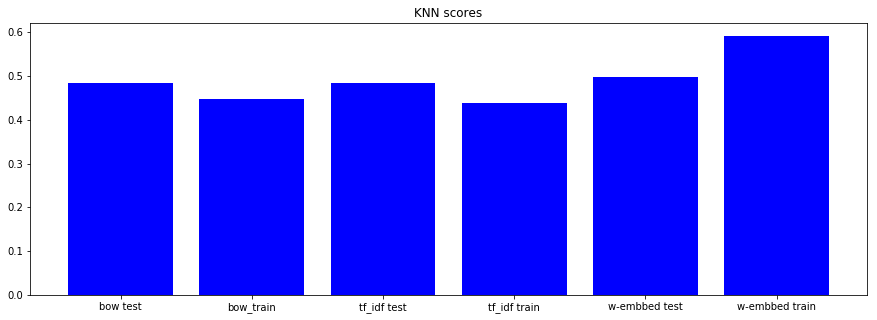

In [50]:
plt.figure(figsize=(15, 5))
plt.title("KNN scores")
plt.bar(range(len(knn_scores)), knn_scores, color="b", align="center")
plt.xticks(x, labels)
plt.show()

## Bonus: RoundRobin Classification

Implementation of **Round Robin Classification** algorithm and executing with BOW, TF_IDF sets

In [51]:
from scipy.sparse import lil_matrix

def Round_Robin(y, ytest, train_data, test_data):
    c1 = c2 = c3 = 0
    for i,v in enumerate(y):
        if v != 0:
            c1 += 1  
        if v != -1:
            c2 += 1
        if v != 1:
            c3 += 1
    pos_neg_x = lil_matrix((c1,3000))
    pos_neg_y = []

    pos_neu_x = lil_matrix((c2, 3000))
    pos_neu_y = []

    neg_neu_x = lil_matrix((c3, 3000))
    neg_neu_y = []
    c1 = c2 = c3 = 0
    for i,v in enumerate(y):
        if v != 0:
            pos_neg_x[c1] = train_data[i]
            pos_neg_y.append(v)
            c1 += 1
        if v != -1:
            pos_neu_x[c1] = train_data[i]
            pos_neu_y.append(v)
            c2 += 1
        if v != 1:
            neg_neu_x[c1] = train_data[i]
            neg_neu_y.append(v)
            c3 += 1
            
    print pos_neg_x.shape, len(pos_neg_y)
    print pos_neu_x.shape, len(pos_neu_y)
    print neg_neu_x.shape, len(neg_neu_y)
    
    #Train Classifiers
    pos_neg_knn = KNeighborsClassifier(n_neighbors=20)
    pos_neg_knn.fit(pos_neg_x, pos_neg_y)

    pos_neu_knn = KNeighborsClassifier(n_neighbors=20)
    pos_neu_knn.fit(pos_neu_x, pos_neu_y)

    neg_neu_knn = KNeighborsClassifier(n_neighbors=20)
    neg_neu_knn.fit(neg_neu_x, neg_neu_y)
    
    #Get predictions
    pos_neg_train_pred = pos_neg_knn.predict_proba(train_data)
    pos_neg_test_pred = pos_neg_knn.predict_proba(test_data)
    pos_neu_train_pred = pos_neu_knn.predict_proba(train_data)
    pos_neu_test_pred = pos_neg_knn.predict_proba(test_data)
    neg_neu_train_pred = neg_neu_knn.predict_proba(train_data)
    neg_neu_test_pred = neg_neu_knn.predict_proba(test_data)
    print neg_neu_train_pred.shape
    
    #Train the final KNN classifier
    train_pred = np.concatenate((pos_neg_train_pred,pos_neu_train_pred, neg_neu_train_pred),axis=1)
    test_pred = np.concatenate((pos_neg_test_pred,pos_neu_test_pred, neg_neu_test_pred),axis=1)
    
    #Run KNN
    fin_classifier = KNeighborsClassifier(n_neighbors=20)
    fin_classifier.fit(train_pred, y)
    
    prediction = fin_classifier.predict(train_pred)
    train_score = f1_score(y, prediction, average='micro')
    
    prediction = fin_classifier.predict(test_pred)
    test_score = f1_score(ytest, prediction, average='micro')
    
    return train_score, test_score

**Bag of Words**

In [52]:
rr_score_bow_train, rr_score_bow_test = Round_Robin(yval, ycor, bow_xtrain, bow_xtest)
print "f1 score on training set: ", rr_score_bow_train
print "f1 score on testing set: ", rr_score_bow_test

(15993, 3000) 15993
(23583, 3000) 23583
(16542, 3000) 16542
(28059, 2)
f1 score on training set:  0.5499839623650166
f1 score on testing set:  0.41655812438944967


**TF-IDF**

In [53]:
rr_score_idf_train, rr_score_idf_test = Round_Robin(yval, ycor, tfidf_train, tfidf_test)
print "f1 score on training set: ", rr_score_idf_train
print "f1 score on testing set: ", rr_score_idf_test

(15993, 3000) 15993
(23583, 3000) 23583
(16542, 3000) 16542
(28059, 2)
f1 score on training set:  0.5640614419615809
f1 score on testing set:  0.42543145555193745
